In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product

def invboxcox(y, lamda):
    if lamda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(y*lamda+1)/lamda)

In [17]:
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
wage

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


# Визуальный анализ ряда #

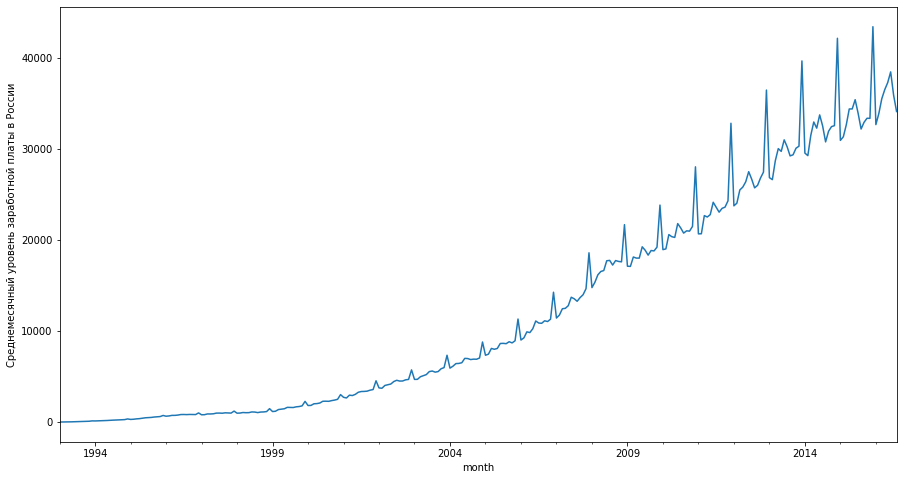

In [22]:
plt.figure(figsize=(15, 8))
wage.WAG_C_M.plot()
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()

**Проверка стационарности и STL-декомпозиция ряда:**

<Figure size 1080x720 with 0 Axes>

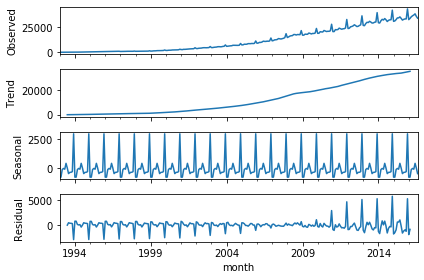

Критерий Дики-Фуллера: 0.9918495954854735


In [71]:
plt.figure(figsize=(15, 10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
plt.show()
print('Критерий Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]))

Cреднемесячный уровень заработной платы в России имеет тренд монотонно увеличивается, сезоность 12 месяцев, и остатка имеет циклически

По критерии Дики-Фуллера ряд не стационарный.

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.2632017541844584
Критерий Дики-Фуллера: p= 0.6968987634832662


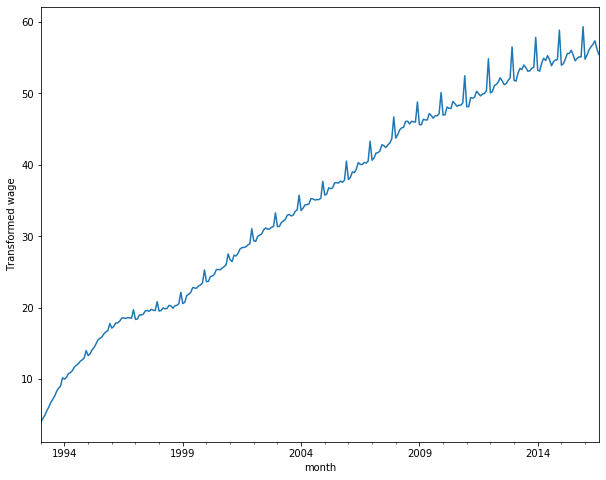

In [37]:
wage['WAG_boxcox'], lamda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize=(10,8))
wage.WAG_boxcox.plot()
plt.ylabel('Transformed wage')
print('Оптимальный параметр преобразования Бокса-Кокса: {}'.format(lamda))
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_boxcox)[1]))

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности (p > 0.05). Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

<Figure size 1080x720 with 0 Axes>

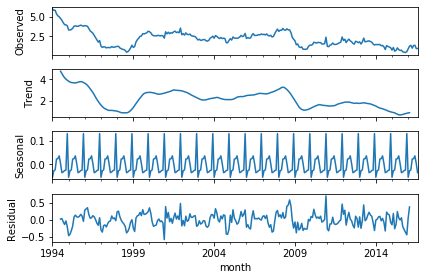

Критерий Дики-Фуллера: p= 0.014697133494791775


In [40]:
wage['WAG_boxcox_diff'] = wage.WAG_boxcox - wage.WAG_boxcox.shift(12)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(wage.WAG_boxcox_diff.dropna()).plot()
plt.show()
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_boxcox_diff.dropna())[1]))

По критерии Дики-Фуллера отвергает гипотезу нестационарности, но сезонное дифференцирование не удалось полностью избавиться от тренда. Попробуем добавить ещё обычное дифференцирование:

<Figure size 1080x720 with 0 Axes>

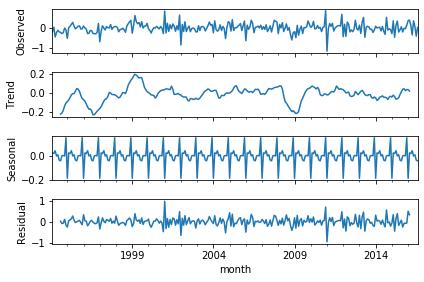

Критерий Дики-Фуллера: p= 5.203603715821937e-08


In [69]:
plt.figure(figsize=(15,10))
wage['WAG_box_diff2'] = wage.WAG_boxcox_diff - wage.WAG_boxcox_diff.shift(1)
sm.tsa.seasonal_decompose(wage.WAG_box_diff2.dropna()).plot()
plt.show()
print('Критерий Дики-Фуллера: p= {}'.format(sm.tsa.stattools.adfuller(wage.WAG_box_diff2.dropna())[1]))

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

### Выбор начальных приближений для p, q, P, Q

Посмотрим на ACF и PACF полученного ряда:

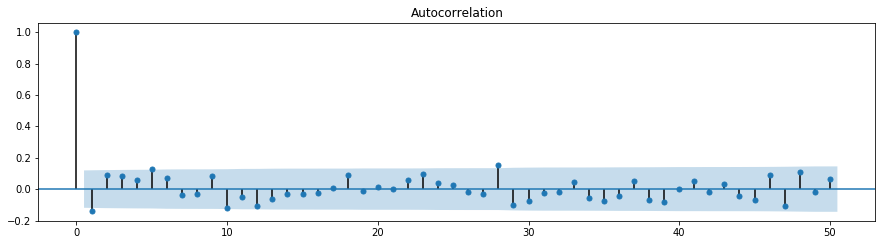

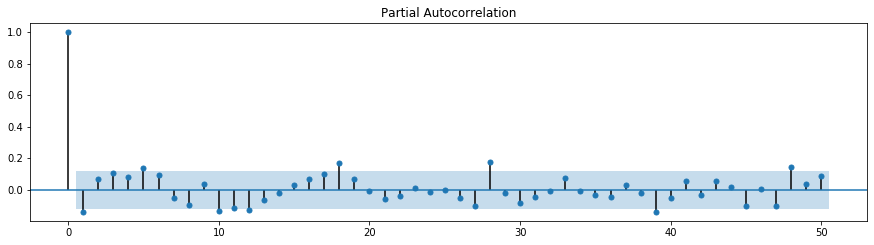

In [45]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_box_diff2.dropna().values.squeeze(), lags=50, ax=ax)
plt.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_box_diff2.dropna().values.squeeze(), lags=50, ax=ax)
plt.show()

Начальные приближения: Q=2, q=1, P=1, p=5

In [57]:
Qs = range(0,3)
qs = range(0,2)
Ps = range(0,2)
ps = range(0,6)
D = 1
d = 1

In [58]:
parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

72

In [59]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    try:
        model = sm.tsa.statespace.SARIMAX(wage.WAG_boxcox, order=(param[0], d, param[1]),
                                         seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('Wrong parameters: ', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    
    results.append([best_param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1min 23s


In [60]:
results_table = pd.DataFrame(results)
results_table.columns = ['Parameters', 'aic']
print(results_table.sort_values(by='aic', ascending=True).head())

      Parameters        aic
71  (5, 1, 1, 2) -13.580536
47  (3, 1, 1, 2) -13.314435
65  (3, 1, 1, 2) -12.972133
59  (3, 1, 1, 2) -11.620978
35  (2, 1, 1, 2)  -9.846528


In [62]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         WAG_boxcox   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, 2, 12)   Log Likelihood                  16.790
Date:                            Wed, 20 May 2020   AIC                            -13.581
Time:                                    16:18:20   BIC                             22.441
Sample:                                01-01-1993   HQIC                             0.882
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2110      0.417      0.506      0.613      -0.607       1.029
ar.L2          0.0807      0.096   

Её остатки:

Критерий Стьюдента: p= 0.22467064612003346
Критерий Дики-Фуллера: p= 0.0


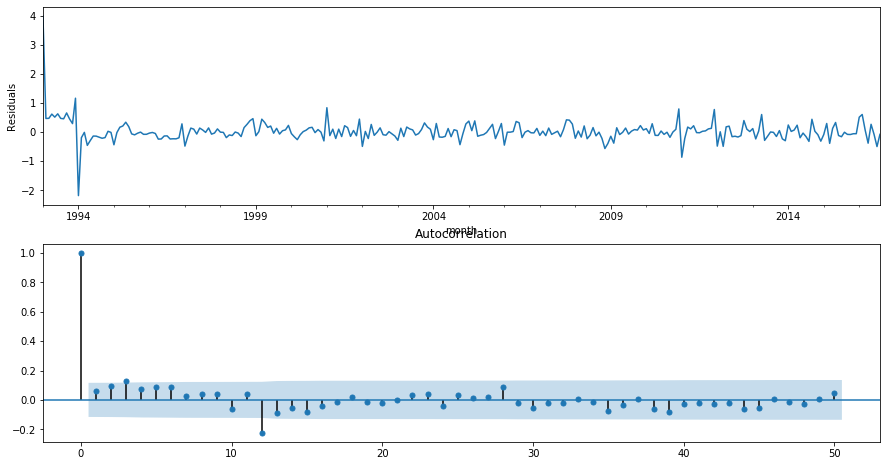

In [73]:
plt.figure(figsize=(15, 8))
plt.subplot(211)
best_model.resid.dropna().plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=50, ax=ax)
print("Критерий Стьюдента: p= {}".format(stats.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print("Критерий Дики-Фуллера: p= {}".format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

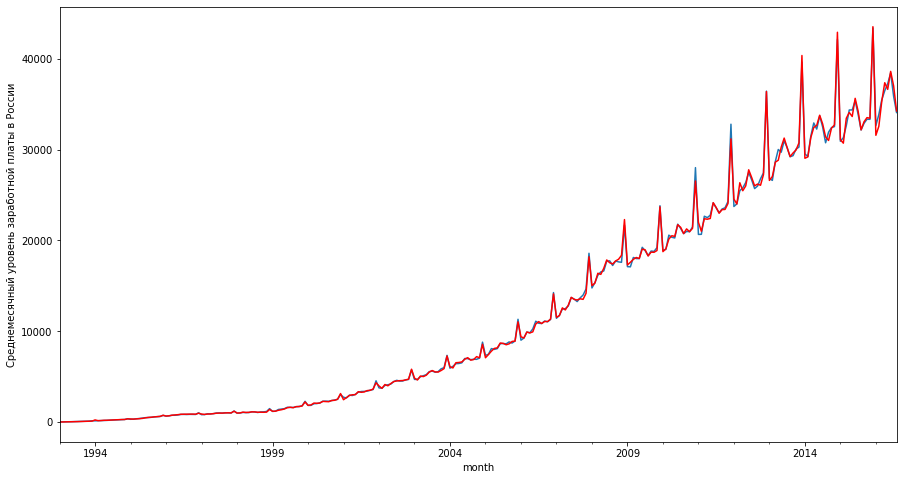

In [79]:
wage['model'] = invboxcox(best_model.fittedvalues, lamda)
plt.figure(figsize=(15, 8))
wage.WAG_C_M.plot()
wage.model.dropna().plot(color='r')
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()

## Прогноз

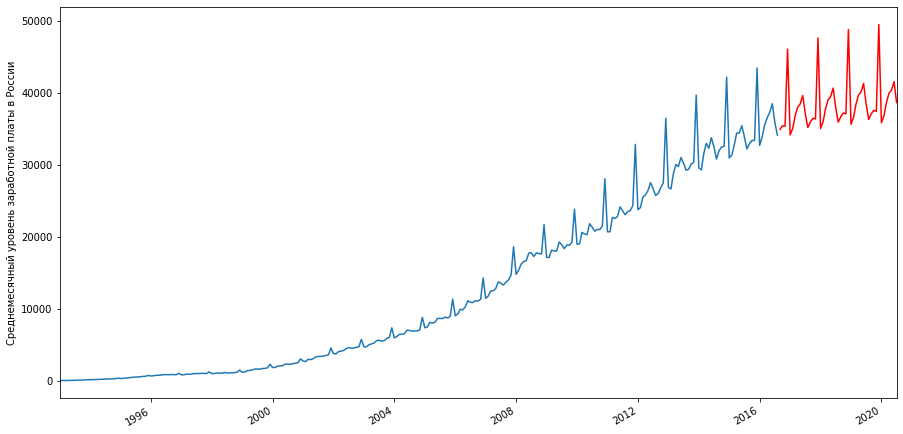

In [80]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 48)]
future = pd.DataFrame(index=date_list, columns=wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=331), lamda)

plt.figure(figsize=(15, 8))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Cреднемесячный уровень заработной платы в России')
plt.show()